# Computer Vision Coursework Submission (IN3060)

**Student name, ID and cohort:** Aliyyah Uddin (210052562) - UG


# Notebook Setup
In this section you should include all the code cells required to test your coursework submission. Specifically:

### Mount Google Drive

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Define Local Path

In the next cell you should assign to the variable `GOOGLE_DRIVE_PATH_AFTER_MYDRIVE` the relative path of this folder in your Google Drive.

**IMPORTANT:** you have to make sure that **all the files required to test your functions are loaded using this variable** (as was the case for all lab tutorials). In other words, do not use in the notebook any absolute paths. This will ensure that the markers can run your functions. Also, **do not use** the magic command `%cd` to change directory.



In [26]:
import os

GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = 'Colab Notebooks/CW_Folder_UG'
GOOGLE_DRIVE_PATH = os.path.join('drive', 'My Drive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)
print(os.listdir(GOOGLE_DRIVE_PATH))

# Unzip dataset
zip_path = os.path.join(GOOGLE_DRIVE_PATH, 'CW_Dataset.zip')
!cp '{zip_path}' .
!yes | unzip -q CW_Dataset.zip
!rm CW_Dataset.zip

['Code', 'Models', 'CW_Dataset.zip', 'Personal_Dataset', 'test_functions.ipynb']
replace __MACOSX/._CW_Dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CW_Dataset/._test? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CW_Dataset/._train? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CW_Dataset/test/._images? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CW_Dataset/test/._labels? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CW_Dataset/train/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CW_Dataset/train/._.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CW_Dataset/train/._images? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CW_Dataset/train/._labels? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CW_Dataset/test/images/image_2711.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace __MACOSX/CW_Dataset/test/images/._image_2711.jpeg? [y]es, [n]o, [A]ll, [N]one, [r]ename: replace CW_Dataset/test/images/im

### Load packages

In the next cell you should load all the packages required to test your functions.

In [27]:
import sys, random, cv2
from skimage import io, transform, color, img_as_ubyte
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import MiniBatchKMeans
from sklearn import svm, metrics
from joblib import dump, load
%matplotlib inline
!pip install opencv-python==4.5.5.64
!pip show opencv-python

Name: opencv-python
Version: 4.5.5.64
Summary: Wrapper package for OpenCV python bindings.
Home-page: https://github.com/skvark/opencv-python
Author: 
Author-email: 
License: MIT
Location: /usr/local/lib/python3.10/dist-packages
Requires: numpy, numpy, numpy, numpy
Required-by: dopamine-rl, imgaug


### Load models

In the next cell you should load all your trained models for easier testing of your functions. Avoid to load them within `MaskDetection` to avoid having to reload them each time.

In [28]:
def load_dataset(path, desired_height, desired_width):
    images = []
    labels = []
    label_files = [file for file in os.listdir(os.path.join(path, 'labels')) if file.endswith('.txt')]
    for label_file in label_files:
        with open(os.path.join(path, 'labels', label_file), 'r') as myFile:
            label = int(myFile.read().strip())
            labels.append(label)
        image_name = label_file.replace('.txt', '.jpeg')
        image_path = os.path.join(path, 'images', image_name)
        image = io.imread(image_path)
        image = transform.resize(image, (desired_height, desired_width))
        images.append(image)
    return images, labels

path_to_trainset = 'CW_Dataset/train'
X_train, y_train = load_dataset(path_to_trainset, desired_height=28, desired_width=28)

def extract_hog_features(images):
    hog_features = []
    for image in images:
        HOG_des = hog(image, orientations=8, pixels_per_cell=(16, 16),
                      cells_per_block=(1, 1), visualize=False, channel_axis=2)
        hog_features.append(HOG_des)
    return np.array(hog_features)

X_train_hog = extract_hog_features(X_train)

# Train Model 1 (HOG + SVM)
def train_linear_SVM(X_train, y_train):
  """Train linear SVM"""
  classifier = svm.SVC(kernel='linear')
  classifier.fit(X_train, y_train)
  return classifier
svm_classifier = train_linear_SVM(X_train_hog, y_train)

# Train Model 2 (HOG + MLP)
mlp_classifier = MLPClassifier(hidden_layer_sizes=(50, 100), max_iter=100, alpha=1e-4,
                               solver='sgd', verbose=False, random_state=1,
                               learning_rate_init=.1)
mlp_classifier.fit(X_train_hog, y_train)

#Train Model 3 (SIFT + SVM)
sift = cv2.SIFT_create()

des_list = []
y_train_list = []

for i in range(len(X_train)):
    img = img_as_ubyte(color.rgb2gray(X_train[i]))
    kp, des = sift.detectAndCompute(img, None)
    if des is not None:
        des_list.append(des.astype(np.float32))
        y_train_list.append(y_train[i])

des_array = np.vstack(des_list)
k = len(np.unique(y_train)) * 10
batch_size = des_array.shape[0] // 4
kmeans = MiniBatchKMeans(n_clusters=k, batch_size=batch_size, n_init='auto').fit(des_array)

hist_list = []
idx_list = []

for des in des_list:
    hist = np.zeros(k, dtype=np.float32)

    idx = kmeans.predict(des)
    idx_list.append(idx)
    for j in idx:
        hist[j] = hist[j] + (1 / len(des))
    hist_list.append(hist)

hist_array = np.vstack(hist_list)
sift_classifier = svm.SVC(kernel='rbf')
sift_classifier.fit(hist_array, y_train_list)

def extract_sift_descriptors(images):
    sift_descriptors = []
    for image in images:
        if image.ndim == 3 and image.shape[-1] == 4:
            img_gray = color.rgb2gray(image[:, :, :3])
        elif image.ndim == 3:
            img_gray = color.rgb2gray(image)
        else:
            img_gray = image

        img_ubyte = img_as_ubyte(img_gray)
        kp, des = sift.detectAndCompute(img_ubyte, None)
        if des is not None:
            sift_descriptors.append(des.astype(np.float32))
        else:
            sift_descriptors.append(np.zeros((1, 128), dtype=np.float32))
    return sift_descriptors

def compute_sift_histograms(sift_descriptors):
    sift_hist = []
    for des in sift_descriptors:
        hist = np.zeros(k, dtype=np.float32)
        idx = kmeans.predict(des)
        for j in idx:
            hist[j] += 1
        sift_hist.append(hist)
    return np.vstack(sift_hist)

# Test MaskDetection

This section should allow a quick test of the `MaskDetection` function. First, add cells with the code needed to load the necessary subroutines to make `MaskDetection` work.

In [29]:
def MaskDetection(path_to_testset, model_type):
    X_test, y_test = load_dataset(path_to_testset, desired_height=28, desired_width=28)

    if model_type == 'hog_svm':
        X_test_hog = extract_hog_features(X_test)
        y_pred = svm_classifier.predict(X_test_hog)
    elif model_type == 'hog_mlp':
        X_test_hog = extract_hog_features(X_test)
        y_pred = mlp_classifier.predict(X_test_hog)
    elif model_type == 'sift_svm':
        sift_descriptors = extract_sift_descriptors(X_test)
        sift_hist_array = compute_sift_histograms(sift_descriptors)
        y_pred = sift_classifier.predict(sift_hist_array)
    else:
        raise ValueError("Unknown model type")

    test_sample = random.sample(range(len(X_test)), 4)
    fig, axes = plt.subplots(1, 4, figsize=(10, 5), sharex=True, sharey=True)
    ax = axes.ravel()
    for i in range(4):
        ax[i].imshow(X_test[test_sample[i]], cmap='gray')
        ax[i].set_title(f'Label: {y_test[test_sample[i]]} \n Prediction: {y_pred[i]}')
        ax[i].set_axis_off()
    fig.tight_layout()
    plt.show()
    return y_pred

Then, make a call to the `MaskDetection` function to see what results it produces. You must also indicate the syntax needed to test your different models.

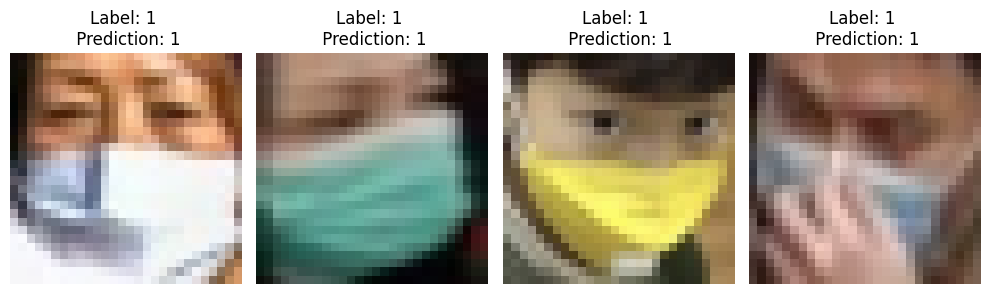

In [30]:
# Syntax for the next function is the following:
#
# MaskDetection(path_to_testset, model_type)
#
# where model_type can be one of
#   - hog_svm
#   - hog_mlp
#   - sift_svm
#
# Change the model_type parameter to the one you wish to test

path_to_testset = 'CW_Dataset/test'

y_pred = MaskDetection(path_to_testset, model_type='hog_svm')

# Test MaskDetection in the wild

This section should allow a quick test of the `MaskDetection` on your `Personal_Dataset`.

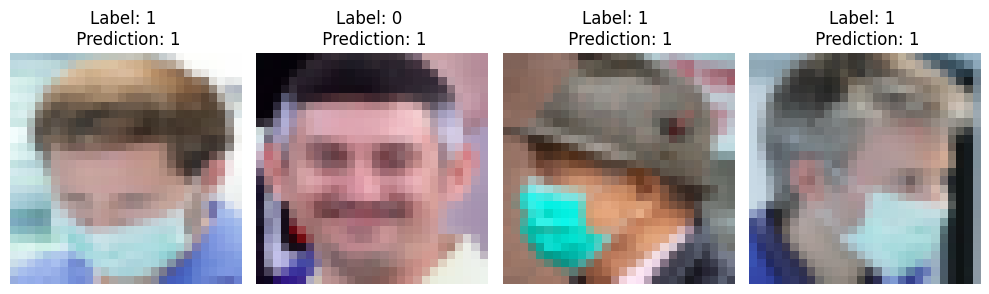

In [31]:
# Syntax for the next function is the following:
#
# MaskDetection(path_to_testset, model_type)
#
# where model_type can be one of
#   - hog_svm
#   - hog_mlp
#   - sift_svm
#
# Change the model_type parameter to the one you wish to test

path_to_testset = os.path.join(GOOGLE_DRIVE_PATH, 'Personal_Dataset')

y_pred = MaskDetection(path_to_testset, model_type='hog_mlp')